C:\Users\hsham\AppData\Local\Temp\ipykernel_22204\75026799.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


               Model       MSE       MAE        R²      RMSE      MAPE
0      Random Forest  2.243845  0.844160  0.554856  1.497947  0.075308
1  Gradient Boosting  2.210260  0.864936  0.561519  1.486694  0.075876
2            XGBoost  2.594113  0.888713  0.485368  1.610625  0.078378
3  Linear Regression  3.048070  1.068264  0.395310  1.745872  0.090285


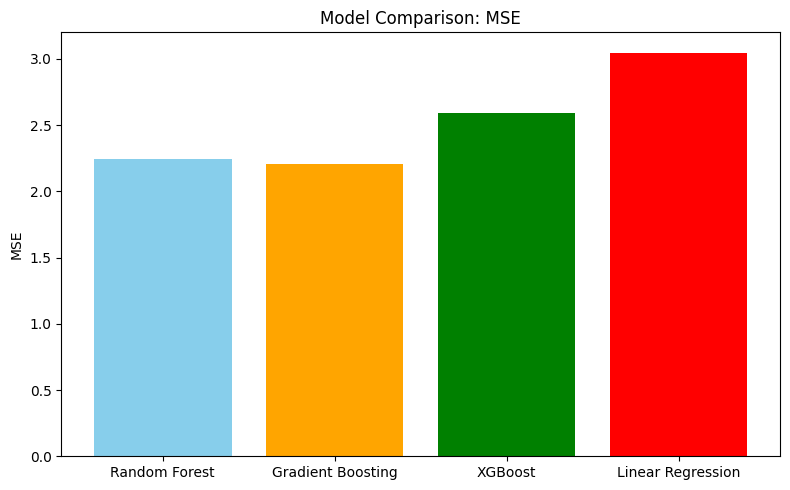

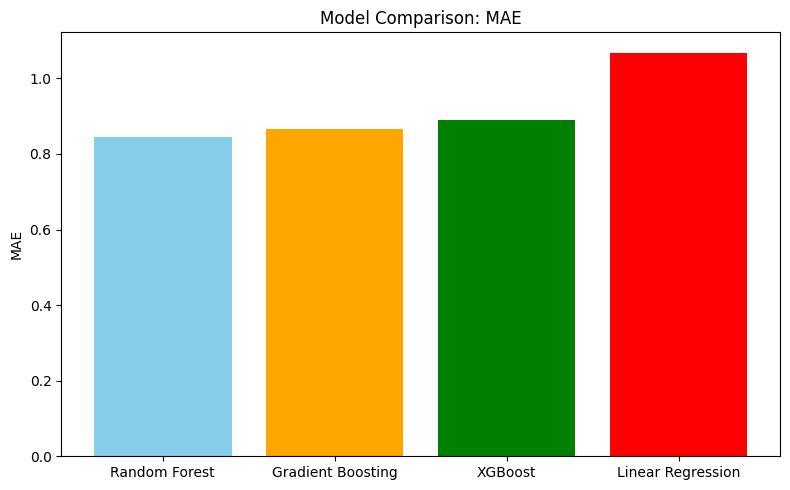

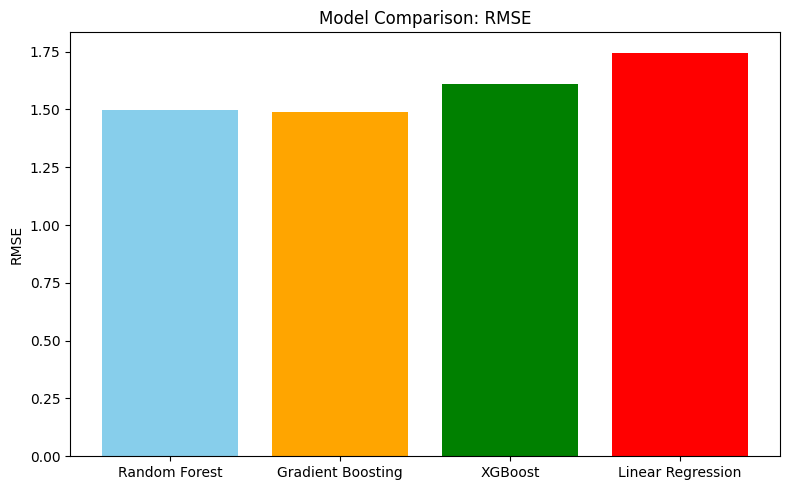

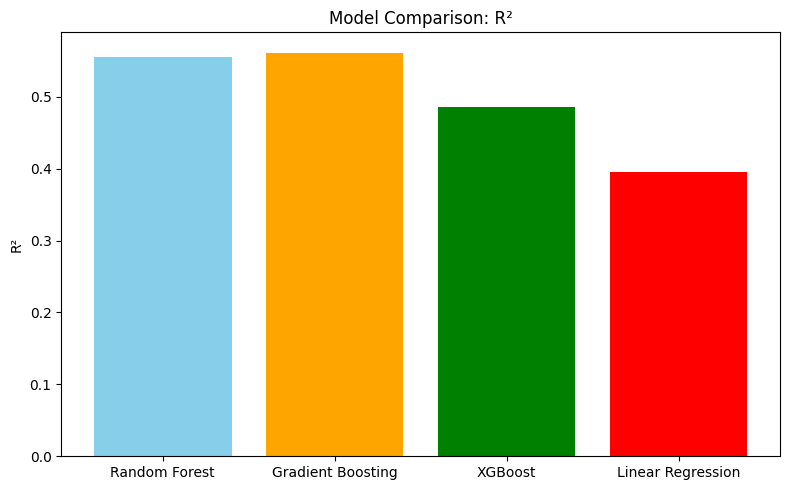

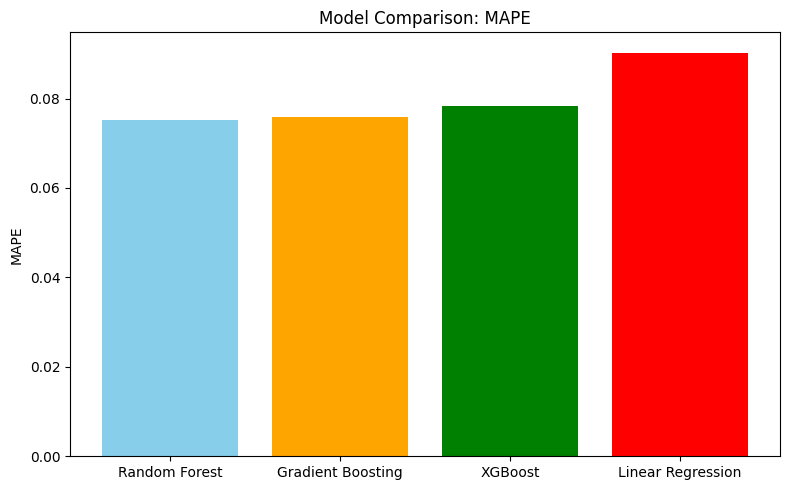

Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
Test R²: 0.5576871456045942


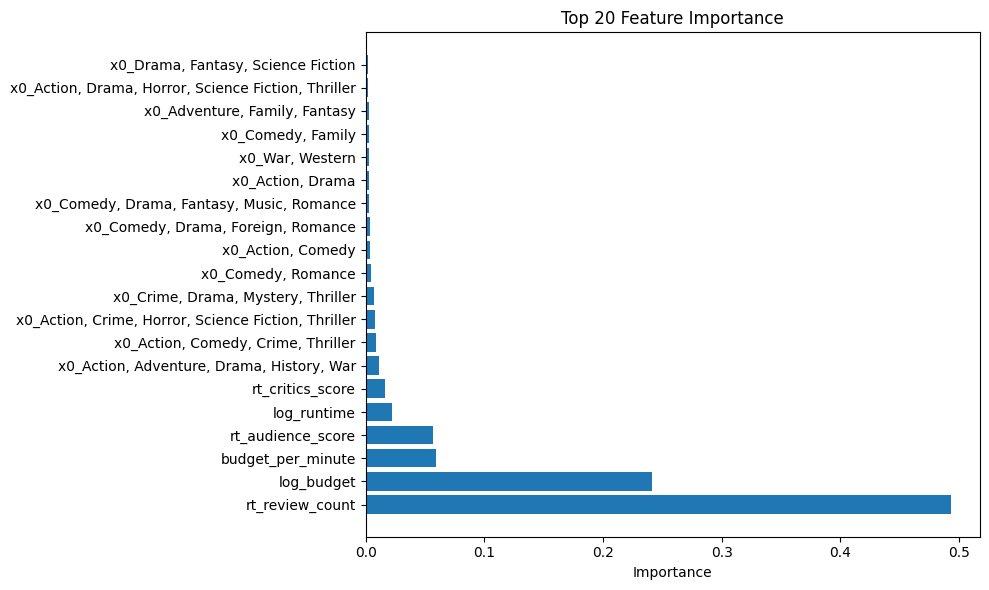

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from collections import Counter
import ast

df_movies = pd.read_csv(r"data/rotten_tomatoes_5000_movies.csv")
df_credit = pd.read_csv(r"data/rotten_tomatoes_5000_credits.csv")

# Merge df_movies and df_credit on 'rt_movie_id'
df = pd.merge(df_movies, df_credit, on='rt_movie_id', how='left')

# Remove rows where 'rt_box_office' is 0
df = df[df['rt_box_office'] != 0]

# **1. Feature Engineering**

# Parse genres, actors, and directors safely
def parse_genres(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres]
    except:
        return []

def parse_actors(actors_str):
    try:
        actors = ast.literal_eval(actors_str)
        return [actor['name'] for actor in actors]
    except:
        return []

def parse_directors(staff_str):
    try:
        staff = ast.literal_eval(staff_str)
        return [staff_member['name'] for staff_member in staff if staff_member['job'] == 'Director']
    except:
        return []

# Merge datasets
df = pd.merge(df_movies, df_credit, on='rt_movie_id', how='left')
df = df[df['rt_box_office'] != 0]  # Remove rows with zero box office

# Parse columns
df['parsed_genres'] = df['rt_genres'].apply(parse_genres)
df['parsed_actors'] = df['rt_actors'].apply(parse_actors)
df['parsed_directors'] = df['rt_staff'].apply(parse_directors)

# Create genre combinations as a single feature
df['genre_combination'] = df['parsed_genres'].apply(lambda x: ', '.join(sorted(x)) if x else '')

# Famous actors and directors
all_actors = [actor for actors_list in df['parsed_actors'] for actor in actors_list]
actor_counts = Counter(all_actors)
top_actors = [actor for actor, _ in actor_counts.most_common(30)]

all_directors = [director for directors_list in df['parsed_directors'] for director in directors_list]
director_counts = Counter(all_directors)
top_directors = [director for director, _ in director_counts.most_common(10)]

df['has_famous_actor'] = df['parsed_actors'].apply(lambda x: any(actor in top_actors for actor in x)).astype(int)
df['has_famous_director'] = df['parsed_directors'].apply(lambda x: any(director in top_directors for director in x)).astype(int)

# Create derived features
df['log_budget'] = np.log1p(df['rt_production_budget'])
df['log_runtime'] = np.log1p(df['rt_runtime'])
df['budget_per_minute'] = df['rt_production_budget'] / df['rt_runtime']
df['release_year'] = pd.to_datetime(df['rt_release_date']).dt.year
df['release_month'] = pd.to_datetime(df['rt_release_date']).dt.month
df['age_of_movie'] = 2025 - df['release_year']

# Remove invalid rows
df = df.dropna(subset=['budget_per_minute'])

# Target and features
y = np.log1p(df['rt_box_office'])
X = df[['log_budget', 'log_runtime', 'budget_per_minute', 'release_year', 'release_month',
        'age_of_movie', 'rt_critics_score', 'rt_audience_score', 'rt_review_count',
        'has_famous_actor', 'has_famous_director', 'genre_combination']]

# **2. Preprocessing**
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ['genre_combination']  # Specify categorical columns explicitly

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# **3. Train 4 Models**
models = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('Linear Regression', LinearRegression())
]

results = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for model_name, model in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results.append((model_name, mse, mae, r2, rmse, mape))

# **4. Model Comparison**
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'MAE', 'R²', 'RMSE', 'MAPE'])
print(results_df)

# Plot metrics
metrics = ['MSE', 'MAE', 'RMSE', 'R²', 'MAPE']
for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.bar(results_df['Model'], results_df[metric], color=['skyblue', 'orange', 'green', 'red'])
    plt.title(f'Model Comparison: {metric}')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

# **5. Hyperparameter Tuning for Best Model**
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
best_model = [model for name, model in models if name == best_model_name][0]

param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5, 10]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 10],
        'model__learning_rate': [0.05, 0.1],
        'model__min_child_weight': [1, 3]
    }
}

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
grid_search = GridSearchCV(pipeline, param_grids[best_model_name], cv=5)
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test R²: {r2_score(y_test, y_pred)}")

# **6. Feature Importance**
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    feature_names = numerical_cols.tolist() + list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out())
    feature_importances = best_model.named_steps['model'].feature_importances_
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(feature_importances)[::-1]
    plt.barh(np.array(feature_names)[sorted_idx][:20], feature_importances[sorted_idx][:20])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
